__собираем статистики по объявлениям о продаже домов__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Ср 19 июн 2024 13:04:33 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_house.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

26020

,title,address,latitude,longitude,priceM,dt
22765,"дом 30,6 м² на участке 5,8 сот.","севастополь,садовое товарищество автомобилист,181",44.52,33.50,8.00,2024-06-19
15539,дом 62 м² на участке 5 сот.,"севастополь,снт сапун-гора,ул.летчицы себровой",44.56,33.57,6.30,2024-06-13
21306,дом 70 м² на участке 4 сот.,"севастополь,тсн союз,107",44.51,33.52,8.50,2024-06-14


---

In [4]:
# df_ = pd.read_pickle('data/2023/data_house.pkl').rename(columns={'adr':'address'})
# df_['dt'] = df_['ts'].dt.date
# display( len(df_) )
# display( df_.sample(3)[cols] )

In [5]:
# df_ = (
#         df_
#         .dropna(subset=['dt','url'])
#         .drop_duplicates(['dt','url'])
#         .drop(columns=['adr_orig','obj_name','avito_page'])
#     )
# display( len(df_) )
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# display( df_.sample(3)[cols] )

In [6]:
# # history_date = df_['dt'].max()
# history_date = pd.to_datetime('2023-01-10').date()
# display(history_date)

In [7]:
# df = pd.concat([df,df_]).reset_index(drop=True)
# display( len(df) )
# del df_

---

In [8]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

---

In [9]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

26020

26020

In [10]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_part) & (house_area>40.) & (priceM<15.)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

26020

19134

19106

In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt
14920,"дом 80,3 м² на участке 3,7 сот.","севастополь,нахимовский район ,любимовка",44.67,33.55,8.40,2024-06-13
3597,"дом, 90 м², 4 сот., садоводство","севастополь,р-н балаклавский,надежда садоводческое товарищество,6",44.53,33.50,4.80,2024-06-13
13738,"дом 56,8 м² на участке 4,5 сот.","севастополь,каспийская ул.,2",44.59,33.53,7.72,2024-06-17


---

In [12]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
print( dt_min, ' : ',dt_max )
# display( dt_min,history_date,dt_max )

2024-06-07  :  2024-06-19


In [13]:
gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")')

In [14]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [15]:
# display( len(gdf_history) )
# display( len(gdf) )

---

In [16]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [17]:
# gdf['place'].unique()

# общая статистика

In [18]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [19]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [20]:
# gdf[ gdf['address'].str.match(r'.*ялта.*') ]
# gdf[ gdf['address'].str.match(r'.*окуневка.*') ]
# gdf[ gdf['address'].str.match(r'.*заветное.*') ]

In [21]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [22]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        #gdf.groupby(['place','house_size_category','month'],observed=True)
        gdf.groupby(['place','house_size_category','week'],observed=True)
    
        ['priceM'].describe(percentiles=percentiles)
    )

display( stat )

count  mean  std  \
place       house_size_category week                                       
bahchisaray 30-50               2024-06-03/2024-06-09   29.00  3.92 1.61   
                                2024-06-10/2024-06-16  113.00  3.92 1.59   
                                2024-06-17/2024-06-23   54.00  3.96 1.65   
            50-70               2024-06-03/2024-06-09   70.00  5.57 1.92   
                                2024-06-10/2024-06-16  287.00  5.74 2.09   
                                2024-06-17/2024-06-23  144.00  5.66 2.06   
            70-110              2024-06-03/2024-06-09   69.00  6.66 3.06   
                                2024-06-10/2024-06-16  277.00  6.57 2.93   
                                2024-06-17/2024-06-23  135.00  6.65 2.91   
            110-180             2024-06-03/2024-06-09   41.00  8.28 3.34   
                                2024-06-10/2024-06-16  149.00  8.21 3.34   
                                2024-06-17/2024-06-23   85.00  8.37 3.39   
            180-300             2024-06-03/2024-06-09   27.00  9.49 3.24   
                                2024-06-10/2024-06-16  107.00  9.25 3.08   
                                2024-06-17/2024-06-23   51.00  9.51 3.29   
            300+                2024-06-03/2024-06-09    4.00 12.25 1.71   
                                2024-06-10/2024-06-16   20.00 12.40 1.39   
                                2024-06-17/2024-06-23   11.00 12.18 1.54   
sevastopol  30-50               2024-06-03/2024-06-09  110.00  5.21 1.87   
                                2024-06-10/2024-06-16  409.00  5.40 1.94   
                                2024-06-17/2024-06-23  254.00  5.46 2.02   
            50-70               2024-06-03/2024-06-09  294.00  6.26 2.11   
                                2024-06-10/2024-06-16 1212.00  6.40 2.17   
                                2024-06-17/2024-06-23  787.00  6.56 2.25   
            70-110              2024-06-03/2024-06-09  857.00  7.98 2.31   
                                2024-06-10/2024-06-16 3465.00  8.08 2.35   
                                2024-06-17/2024-06-23 2277.00  8.14 2.33   
            110-180             2024-06-03/2024-06-09  688.00  9.53 2.36   
                                2024-06-10/2024-06-16 2911.00  9.68 2.38   
                                2024-06-17/2024-06-23 1856.00  9.82 2.29   
            180-300             2024-06-03/2024-06-09  139.00 10.45 2.53   
                                2024-06-10/2024-06-16  621.00 10.65 2.59   
                                2024-06-17/2024-06-23  428.00 10.65 2.67   
            300+                2024-06-03/2024-06-09    8.00  8.35 3.76   
                                2024-06-10/2024-06-16   54.00  9.33 3.26   
                                2024-06-17/2024-06-23   27.00  8.75 3.44   
sudak       30-50               2024-06-03/2024-06-09   10.00  9.20 3.66   
                                2024-06-10/2024-06-16   42.00  9.43 3.58   
                                2024-06-17/2024-06-23   30.00  9.49 3.87   
            50-70               2024-06-03/2024-06-09   21.00  7.46 2.27   
                                2024-06-10/2024-06-16   74.00  7.59 2.33   
                                2024-06-17/2024-06-23   39.00  8.06 2.19   
            70-110              2024-06-03/2024-06-09   54.00  8.89 2.82   
                                2024-06-10/2024-06-16  220.00  8.89 2.75   
                                2024-06-17/2024-06-23  117.00  8.97 2.61   
            110-180             2024-06-03/2024-06-09   28.00  9.08 3.43   
                                2024-06-10/2024-06-16  113.00  9.19 3.38   
                                2024-06-17/2024-06-23   77.00  9.37 3.29   
            180-300             2024-06-03/2024-06-09   16.00 10.23 3.66   
                                2024-06-10/2024-06-16   64.00 10.33 3.52   
                                2024-06-17/2024-06-23   40.00 10.69 3.42   
            300+            

In [23]:
stat.reset_index()['house_size_category'].unique()

['30-50', '50-70', '70-110', '110-180', '180-300', '300+']
Categories (6, object): ['30-50' < '50-70' < '70-110' < '110-180' < '180-300' < '300+']

In [24]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
# sizes = stat.reset_index()['house_size_category'].unique()
sizes = ['50-70', '70-110','110-180', '180-300' ]
# sizes = ['50-70', '70-150','150-300' ]
display(sizes)

['50-70', '70-110', '110-180', '180-300']

In [25]:
# display(len(gdf))
# gdf_ = gdf[ gdf['house_size_category'].isin(sizes) ].reset_index()
# display(len(gdf_))
# gdf_[['title','house_size_category']]

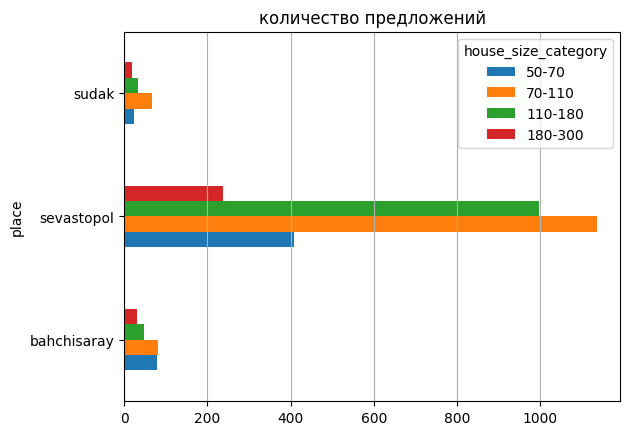

In [26]:
(
gdf
.query('house_size_category in @sizes')
.drop_duplicates(['url'])
.groupby(['house_size_category','place'],observed=True)['url'].count()
.reset_index()
.pivot(index='place', columns='house_size_category', values='url')
.plot.barh(title='количество предложений') #,log=True)
.grid(axis='x')    
)

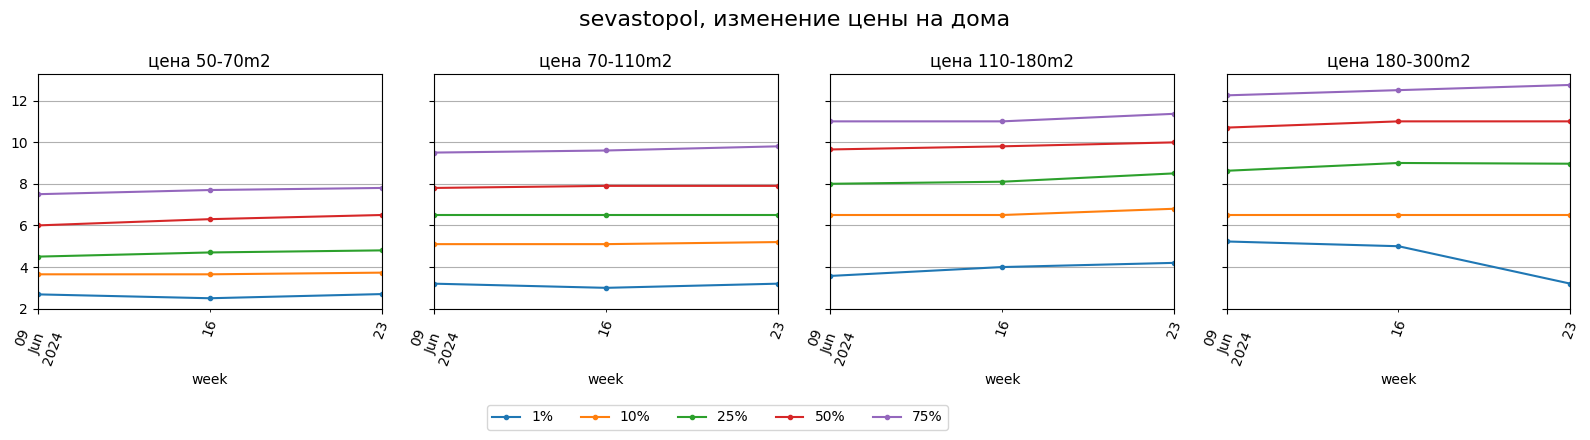

In [27]:
place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

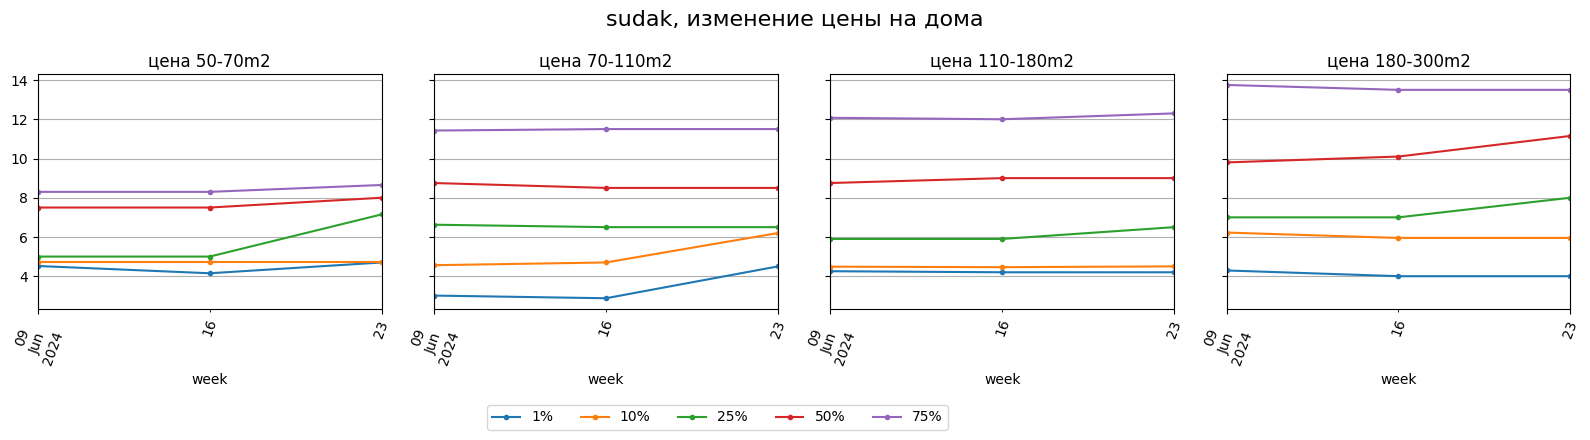

In [28]:
place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [56]:
# dt_now = pd.to_datetime('2024-06-17').date()
dt_now = gdf['dt'].max()

display(len(gdf))
gdf_last = gdf[ gdf['dt'] == dt_now ]
display(len(gdf_last))

19058

2512

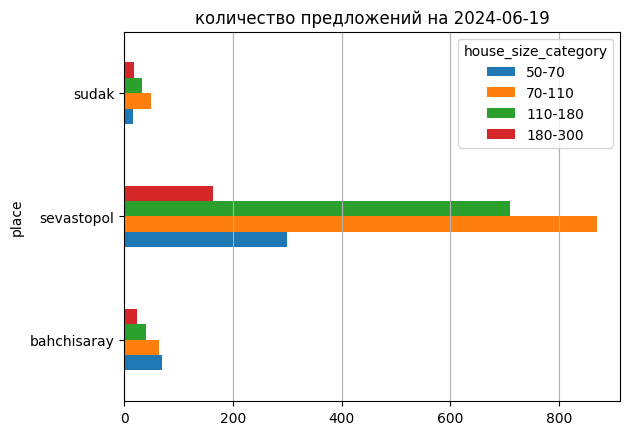

In [57]:
(
gdf_last
.query('house_size_category in @sizes')
.drop_duplicates(['url'])
.groupby(['house_size_category','place'],observed=True)['url'].count()
.reset_index()
.pivot(index='place', columns='house_size_category', values='url')
# .plot.barh(title='количество предложений') #,log=True)
.plot.barh(title='количество предложений на '+ str( dt_now ))
.grid(axis='x')    
)

In [58]:
(
    gdf_last
    .groupby(['place','house_size_category'],observed=False)
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std   min    1%    5%   10%  \
place       house_size_category                                             
bahchisaray 30-50                26.00  4.02 1.68  2.00  2.00  2.05  2.21   
            50-70                70.00  5.68 2.04  1.80  2.01  2.87  3.18   
            70-110               64.00  6.66 2.90  1.50  1.88  2.69  3.36   
            110-180              41.00  8.24 3.44  2.70  3.00  3.50  3.70   
            180-300              24.00  9.73 3.01  4.00  4.00  4.36  6.43   
            300+                  5.00 12.40 1.52 10.00 10.08 10.40 10.80   
sevastopol  30-50                99.00  5.38 2.02  2.50  2.50  2.88  3.40   
            50-70               300.00  6.52 2.22  1.75  2.80  3.50  3.75   
            70-110              869.00  8.17 2.34  1.43  3.20  4.50  5.25   
            110-180             710.00  9.84 2.33  2.30  4.29  5.95  6.67   
            180-300             163.00 10.69 2.70  3.20  3.26  6.01  6.50   
            300+                 10.00  8.28 3.39  3.80  3.86  4.12  4.43   
sudak       30-50                10.00  9.85 3.90  3.99  4.04  4.22  4.45   
            50-70                16.00  8.03 2.23  4.70  4.70  4.70  4.78   
            70-110               49.00  8.86 2.62  4.50  4.50  4.80  6.13   
            110-180              32.00  9.42 3.39  4.20  4.26  4.43  4.60   
            180-300              18.00 10.74 3.39  4.00  4.33  5.66  6.33   
            300+                  6.00 11.08 1.83  9.00  9.00  9.00  9.00   

                                  25%   50%   75%   90%   95%   max  
place       house_size_category                                      
bahchisaray 30-50                2.42  3.95  5.10  5.72  6.25  9.00  
            50-70                4.26  5.47  6.97  8.90  9.75 10.00  
            70-110               4.95  6.40  7.62  9.98 12.50 14.50  
            110-180              5.10  7.75 11.00 12.50 13.50 14.55  
            180-300              7.30 10.00 11.60 13.85 14.26 14.30  
            300+                12.00 13.00 13.00 13.60 13.80 14.00  
sevastopol  30-50                3.77  5.00  6.40  7.92  9.37 12.00  
            50-70                4.80  6.40  7.80  9.26 10.02 14.00  
            70-110               6.50  7.90  9.80 11.50 12.00 14.95  
            110-180              8.50 10.00 11.49 13.00 14.00 15.00  
            180-300              9.00 11.00 12.78 13.98 14.50 14.95  
            300+                 5.72  8.40  9.41 13.10 13.55 14.00  
sudak       30-50                7.12 10.80 13.30 13.55 13.77 14.00  
            50-70                7.37  7.90  8.48 11.15 11.75 12.50  
            70-110               6.50  8.50 11.00 12.40 12.56 13.50  
            110-180              6.35  9.00 12.46 13.45 13.80 14.60  
            180-300              8.38 11.15 13.35 14.95 14.96 14.99  
            300+                 9.50 11.25 12.25 13.00 13.25 13.50

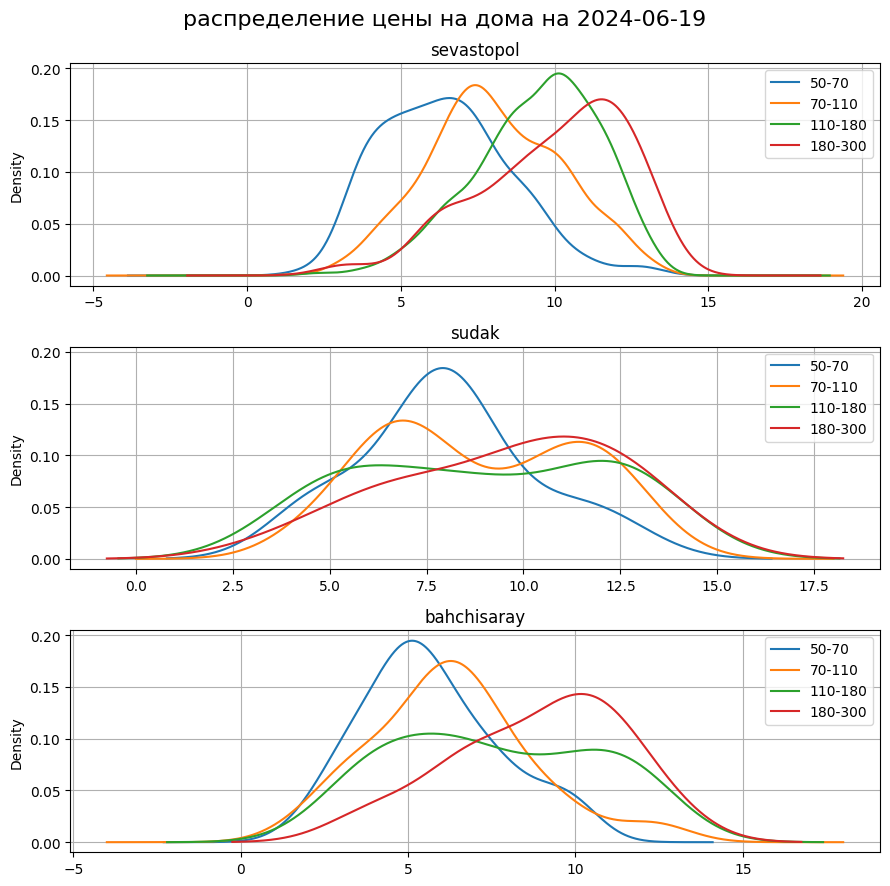

In [59]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

places = ['sevastopol','sudak','bahchisaray']

fig, ax = plt.subplots(len(places),1,figsize=(9,9), sharey=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .query(f' (place=="{p}") & (priceM<{q_95[p]}) & (house_size_category in {sizes})')
        .groupby(['house_size_category'],observed=True)
        ['priceM']
        .plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
fig.suptitle(f'распределение цены на дома на '+ str( dt_now ), fontsize=16)
fig.tight_layout()

In [60]:
# (
# gdf_last
# .query(f' (place=="{p}") & (priceM<{q_95[p]}) & (house_size_category in {sizes})')
# .groupby(['house_size_category'],observed=True)
# ['priceM'].plot.kde()
# )

# цены на карте

In [61]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [62]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [63]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [64]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [65]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [66]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## Судак

In [67]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [68]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [69]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [70]:
display(frames)

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка (старый)","POLYGON ((33.52932 44.59395, 33.53014 44.59336, 33.53265 44.59419, 33.53374 44.59431, 33.53651 44.59412, 33.54230 44.59142, 33.54644 44.58708, 33.54577 44.58522, 33.54406 44.58269, 33.54076 44.58366, 33.53883 44.58383, 33.53664 44.58511, 33.53142 44.58626, 33.53025 44.58780, 33.53048 44.58861, 33.53046 44.58847, 33.53167 44.59039, 33.53092 44.59122, 33.52951 44.59116, 33.52879 44.59244, 33.52895 44.59355, 33.52932 44.59395))"
6,"Севастополь, кр.горка (новый)","POLYGON ((33.54571 44.58517, 33.54652 44.58705, 33.54904 44.58565, 33.55000 44.58541, 33.55054 44.58522, 33.55089 44.58423, 33.55253 44.58415, 33.55326 44.58470, 33.55368 44.58431, 33.55371 44.58320, 33.55522 44.58246, 33.55548 44.58219, 33.55564 44.58115, 33.55564 44.58115, 33.55644 44.58055, 33.55694 44.57984, 33.55718 44.57912, 33.55936 44.57821, 33.56045 44.57706, 33.56229 44.57552, 33.56283 44.57476, 33.55749 44.57202, 33.55674 44.57395, 33.55618 44.57483, 33.55600 44.57601, 33.55286 44.57827, 33.55293 44.57910, 33.55259 44.58172, 33.55269 44.58302, 33.55003 44.58331, 33.54838 44.58436, 33.54571 44.58509, 33.54571 44.58517))"
7,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"
8,"Севастополь, Благополучный","POLYGON ((33.56498 44.57145, 33.56348 44.57083, 33.56274 44.57070, 33.56182 44.57017, 33.56179 44.56990, 33.55967 44.56941, 33.55751 44.57190, 33.55756 44.57213, 33.56302 44.57463, 33.56498 44.57145))"


In [71]:
frames.explore('area_name', legend=True)

In [72]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
'Севастополь, кр.горка (старый)',
'Севастополь, кр.горка (новый)',
'Севастополь, Благополучный',
]

In [73]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_last_local = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

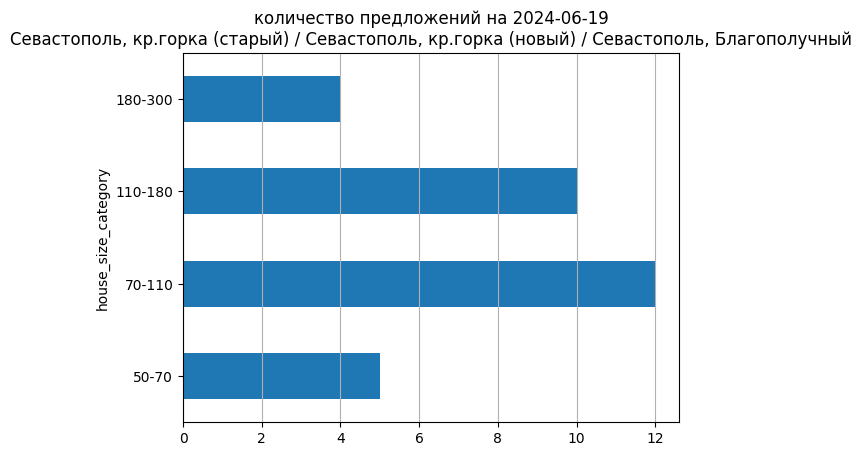

In [74]:
(
    gdf_last_local
    .drop_duplicates('url')
    .query('house_size_category in @sizes')
    .groupby(['house_size_category'], observed=True)['url'].count()
    .plot.barh(title='количество предложений на '+ str(dt_now) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')    
)

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

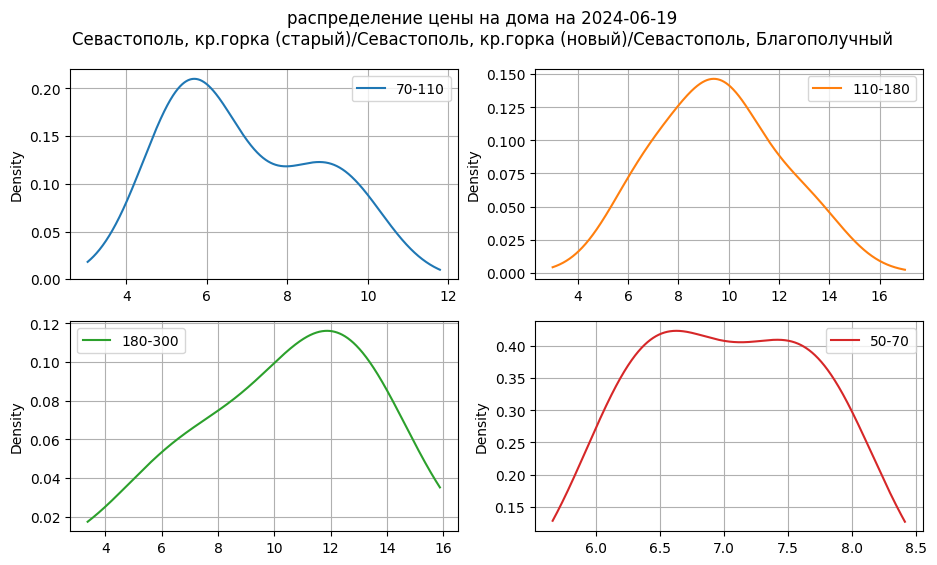

In [75]:
q_95 = gdf_last_local['priceM'].quantile(.95)

# fig, ax = plt.subplots() #figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    .query('house_size_category in @sizes')
    #.groupby(['house_size_category'],observed=True)
    .pivot(columns='house_size_category',values='priceM')
    #['priceM']
    #.count()
    .plot.kde(
        legend=True,
        #ax=ax,
        # title='/'.join(area_name), 
        title=f'распределение цены на дома на '+ str( dt_now )+ '\n'+'/'.join(area_name), 
        grid=True,
        subplots=True,
        layout=(2,2),
        figsize=(11,6),
        sharex=False
    )   
)
#fig.suptitle(f'распределение цены на дома на '+ str( dt_now ), fontsize=16)
#fig.tight_layout()

----

In [76]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [77]:
stat = (
        gdf_local
        # .groupby(['house_size_category','month'],observed=True)
        .groupby(['house_size_category','week'],observed=True)
        ['priceM'].describe(percentiles=percentiles)
        #.dropna()
    )
display( stat )

count  mean  std  min   1%   5%  \
house_size_category week                                                     
30-50               2024-06-03/2024-06-09   3.00  5.90 0.09 5.85 5.85 5.85   
                    2024-06-10/2024-06-16  12.00  5.83 0.14 5.70 5.70 5.70   
                    2024-06-17/2024-06-23   7.00  5.83 0.16 5.70 5.70 5.70   
50-70               2024-06-03/2024-06-09   3.00  7.27 0.79 6.35 6.38 6.49   
                    2024-06-10/2024-06-16  11.00  7.39 1.35 6.35 6.35 6.35   
                    2024-06-17/2024-06-23  13.00  7.03 0.63 6.35 6.35 6.35   
70-110              2024-06-03/2024-06-09  13.00  7.60 2.57 5.22 5.23 5.24   
                    2024-06-10/2024-06-16  47.00  7.45 2.44 5.22 5.22 5.22   
                    2024-06-17/2024-06-23  34.00  7.50 2.39 5.22 5.22 5.22   
110-180             2024-06-03/2024-06-09   9.00 10.22 2.81 6.50 6.50 6.50   
                    2024-06-10/2024-06-16  45.00 10.33 2.62 6.50 6.50 6.50   
                    2024-06-17/2024-06-23  27.00  9.87 2.89 4.25 4.83 6.50   
180-300             2024-06-03/2024-06-09   2.00  8.25 2.47 6.50 6.54 6.67   
                    2024-06-10/2024-06-16  12.00  9.75 2.67 6.50 6.50 6.50   
                    2024-06-17/2024-06-23   9.00 10.36 3.03 6.50 6.50 6.50   

                                           10%  25%   50%   75%   90%   95%  \
house_size_category week                                                      
30-50               2024-06-03/2024-06-09 5.85 5.85  5.85  5.92  5.97  5.99   
                    2024-06-10/2024-06-16 5.70 5.70  5.78  6.00  6.00  6.00   
                    2024-06-17/2024-06-23 5.70 5.70  5.70  6.00  6.00  6.00   
50-70               2024-06-03/2024-06-09 6.62 7.04  7.72  7.72  7.72  7.72   
                    2024-06-10/2024-06-16 6.35 6.35  7.00  7.72  7.72  9.36   
                    2024-06-17/2024-06-23 6.35 6.35  7.00  7.72  7.72  7.72   
70-110              2024-06-03/2024-06-09 5.28 5.50  6.50  8.70  9.60 11.36   
                    2024-06-10/2024-06-16 5.25 5.45  6.50  9.15  9.60 12.68   
                    2024-06-17/2024-06-23 5.25 5.43  6.50  9.38  9.60 11.14   
110-180             2024-06-03/2024-06-09 6.50 9.60 10.00 11.30 13.80 14.39   
                    2024-06-10/2024-06-16 6.50 8.90 10.00 12.25 14.39 14.98   
                    2024-06-17/2024-06-23 6.50 7.40 10.00 12.25 13.50 14.54   
180-300             2024-06-03/2024-06-09 6.85 7.38  8.25  9.12  9.65  9.82   
                    2024-06-10/2024-06-16 6.50 6.50 10.00 12.75 12.75 12.75   
                    2024-06-17/2024-06-23 6.50 6.50 12.75 12.75 12.75 12.75   

                                            max  
house_size_category week                         
30-50               2024-06-03/2024-06-09  6.00  
                    2024-06-10/2024-06-16  6.00  
                    2024-06-17/2024-06-23  6.00  
50-70               2024-06-03/2024-06-09  7.72  
                    2024-06-10/2024-06-16 11.00  
                    2024-06-17/2024-06-23  7.72  
70-110              2024-06-03/2024-06-09 14.00  
                    2024-06-10/2024-06-16 14.00  
                    2024-06-17/2024-06-23 14.00  
110-180             2024-06-03/2024-06-09 14.98  
                    2024-06-10/2024-06-16 14.98  
                    2024-06-17/2024-06-23 14.98  
180-300             2024-06-03/2024-06-09 10.00  
                    2024-06-10/2024-06-16 12.75  
                    2024-06-17/2024-06-23 12.75

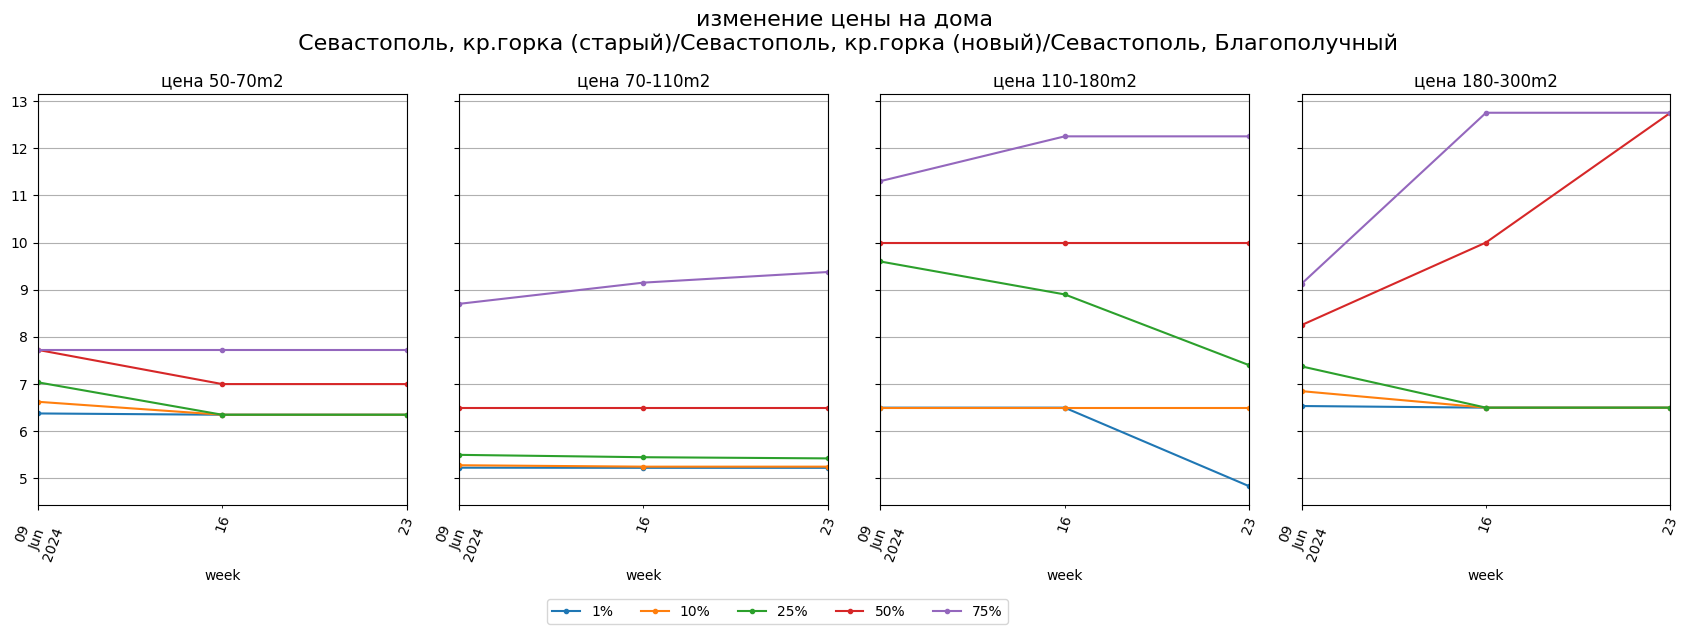

In [78]:
fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на дома\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [52]:
# df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
# df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [53]:
# df.info()

In [54]:
# df.loc[ df['address']=='квартал Старый Город', ['latitude','longitude']] = None
# df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

# df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
# df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
# df.loc[ df['address'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 

# df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [55]:
# df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
# df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

# df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
# df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

# df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
# df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
# df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

# df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
# df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
# df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

# df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
# df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'
# df.loc[ df['address'].str.lower().str.match(r'.*симферопольский район.*'), 'place' ] = 'simferopol'

# df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

# df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
# df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
# df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
# df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
# df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'